## Analyzing Two Years of NYC Bike Share data

In [1]:
import pandas as pd
from pandas import to_datetime
import seaborn as sns
import matplotlib.pyplot as plt

### Monthly Ridership

Read all trips (2019 & 2020) selecting only columns needed

In [2]:
df = pd.read_parquet('tripdata' , columns=['year','month','gender','usertype']) 

Aggregate ride counts by year and month.  Display in wide format.

In [3]:
counts = df.groupby(["year", "month"]).size()
counts.unstack()

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2019,967287,943744,1327960,1766094,1924563,2125370,2181064,2344224,2444900,2092573,1478708,955210
2020,1240596,1146830,1068457,682762,1487890,1882273,2105808,2329514,2488225,2248869,1736704,1088929


Convert year and month from indexes to columns, rename values columns as ridecount

In [4]:
counts=counts.reset_index( level = ['year','month'])
counts.rename(columns = {0:'Ride Count'}, inplace=True)
counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   year        24 non-null     int64
 1   month       24 non-null     int64
 2   Ride Count  24 non-null     int64
dtypes: int64(3)
memory usage: 704.0 bytes


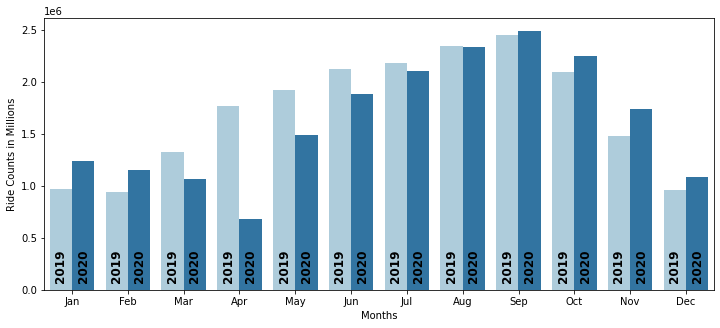

In [5]:
plt.figure(figsize=(12,5))
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax=sns.barplot(data=counts, x="month" , y='Ride Count',  hue='year', palette='Paired' )
ax.set_xlabel("Months") 
ax.set_ylabel("Ride Counts in Millions") 
ax.set_xticklabels(months)
ax.legend_.remove()
y=0
for p in  ax.patches: 
    ax.annotate(counts.year[y],   (p.get_x() + p.get_width()/ 2, 0), rotation=90,\
    ha='center', size=12, fontweight='bold',  xytext=(0, 10),  textcoords='offset points')  
    y+=1

### Ridership by Gender and User Type 
Aggregrate by user type, year and month.  
Show counts by gender (0=unspecified, 1=male, 2=female)

In [6]:
countsg = df.groupby(["usertype","year", "month", "gender"]).size().unstack()

Create `total` by summing across gender value columns.  Then create `pct female` as percentage of total.

In [7]:
countsg['total'] = countsg.sum(axis=1)
countsg['pct female'] = countsg[2] / countsg.total * 100
countsg.head()

gender                    0      1      2   total  pct female
usertype year month                                          
Customer 2019 1       17918  16612   5643   40173   14.046748
              2       19884  19329   7138   46351   15.399883
              3       48623  38816  19219  106658   18.019277
              4      110290  76224  42919  229433   18.706550
              5      138218  97919  58429  294566   19.835623

Convert multi-index to columns

In [8]:
countsg=countsg.reset_index( level = ['usertype','year','month'])

Iterate over usertypes to create separate charts for Subscribers and Customers.  
Use catplot to show separate charts for each year.

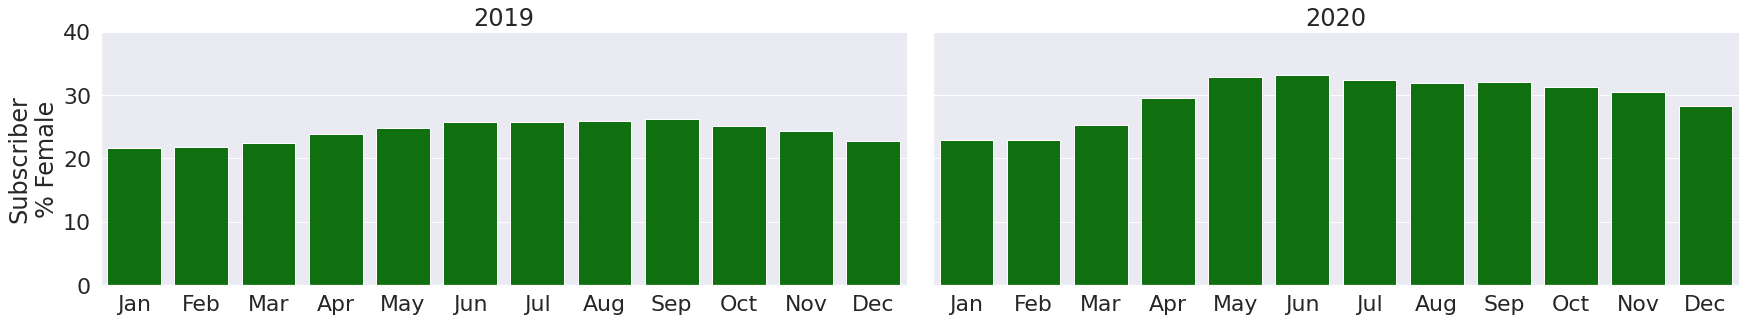

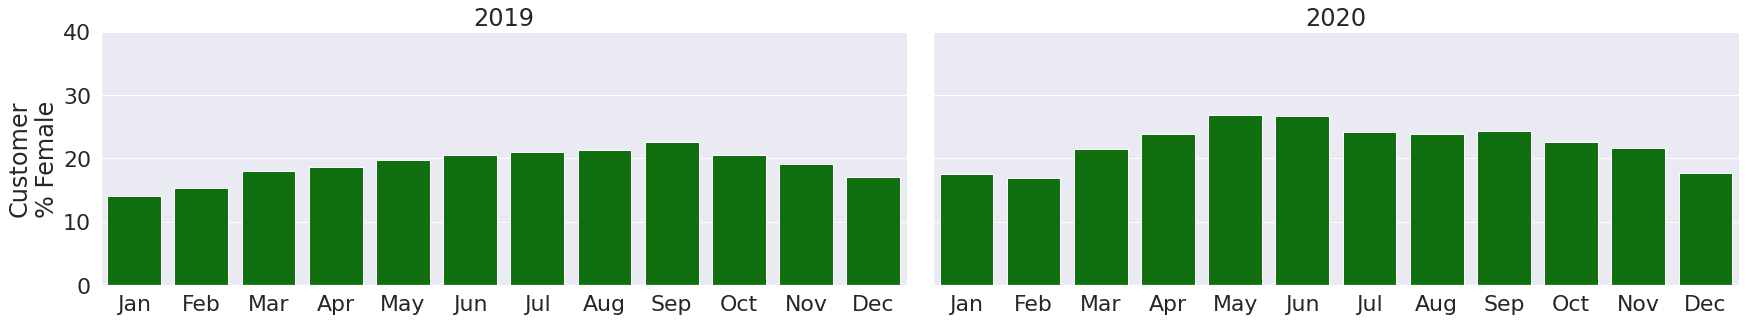

In [9]:
usertypes=['Subscriber','Customer']
sns.set(font_scale = 2)

for u in usertypes:
    ax=sns.catplot(data=countsg[countsg.usertype==u],\
           x="month", y="pct female", col="year",\
           color='Green', kind='bar', height=5, aspect=12/5 ) 
    ax.set_axis_labels("", u + "\n% Female")
    ax.set_xticklabels(months)
    ax.set_titles('{col_name}')
    ax.set(ylim=(0,40))


For all riders (Customers+Subscribers) 

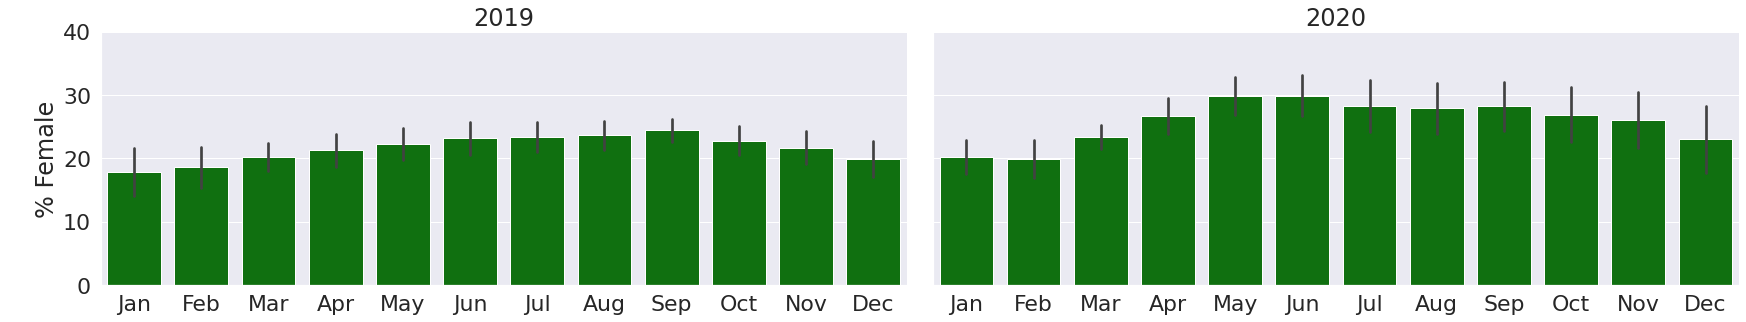

In [10]:
sns.set(font_scale = 2)
ax=sns.catplot(data=countsg,\
      x="month", y="pct female", col="year",\
      color='Green', kind='bar', height=5, aspect=12/5 ) 
ax.set_axis_labels("", "\n% Female")
ax.set_xticklabels(months)
ax.set_titles('{col_name}')
ax.set(ylim=(0,40)) ;

### Ridership by User Type
Aggregate ride count by `year`, `month` and `usertype`

In [11]:
count_type = df.groupby(["year", "month", "usertype"]).size().unstack()
count_type.head()

usertype    Customer  Subscriber
year month                      
2019 1         40173      927114
     2         46351      897393
     3        106658     1221302
     4        229433     1536661
     5        294566     1629997

Create `custpct` as percentage of ride by Customers (vs Subscribers)

In [12]:
custpct = count_type.Customer / (count_type.Customer + count_type.Subscriber) * 100
custpct=custpct.reset_index( level = ['year','month'])
custpct.rename(columns = {0:'Customer Percent'}, inplace=True)

In [13]:
custpct.head()

,year,month,Customer Percent
0,2019,1,4.153162
1,2019,2,4.911395
2,2019,3,8.031718
3,2019,4,12.990985
4,2019,5,15.305604


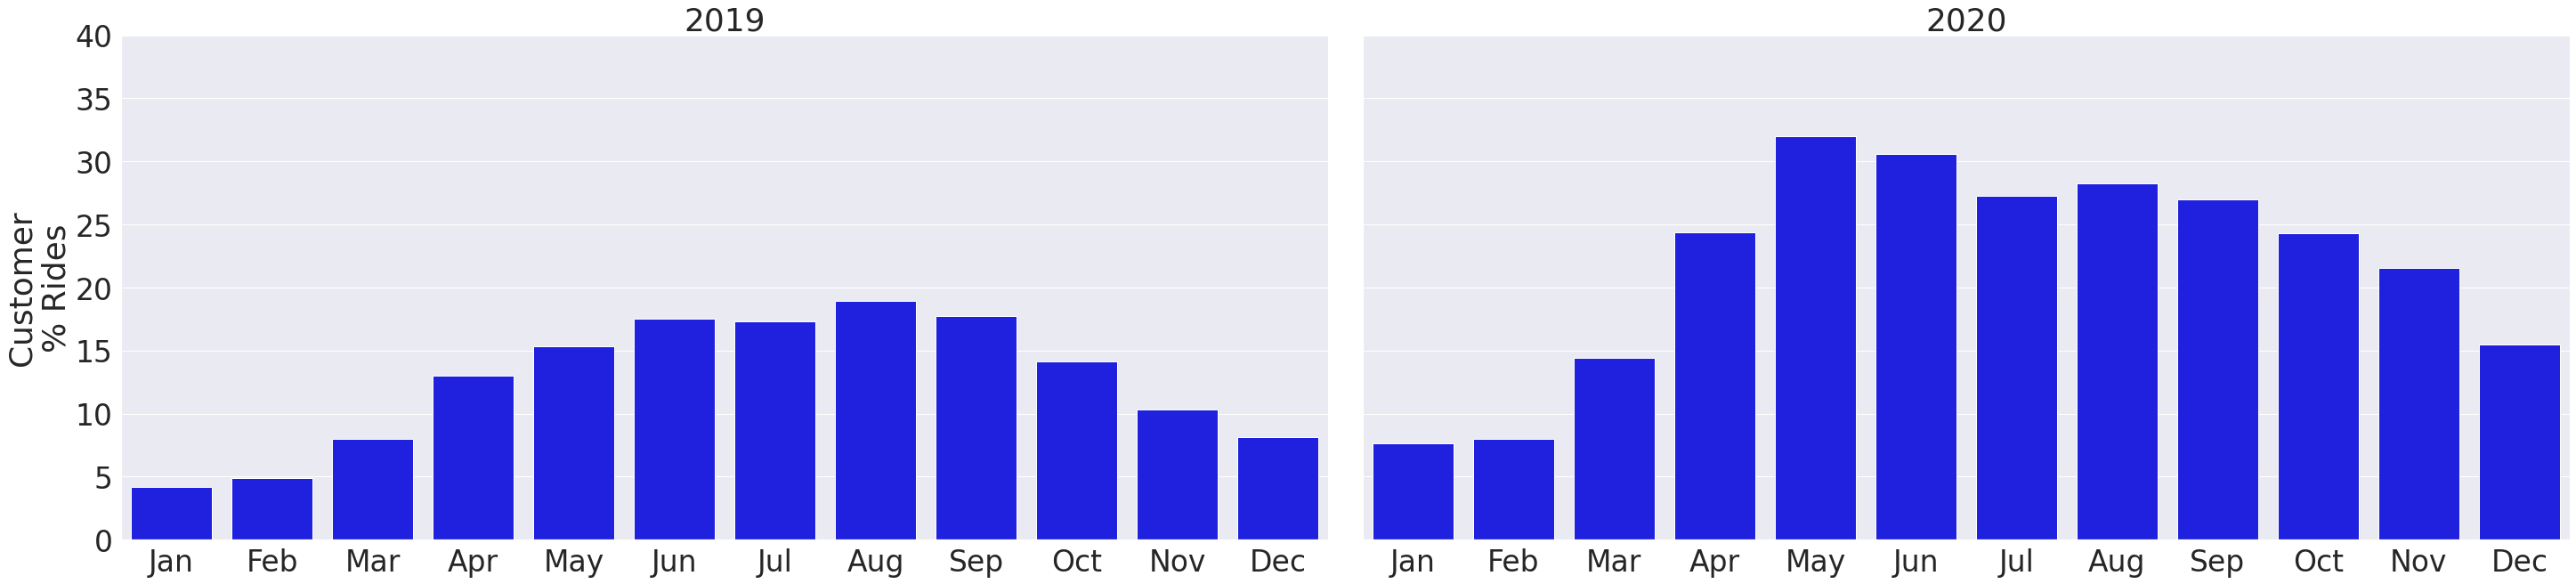

In [14]:
sns.set(font_scale = 3)
ax = sns.catplot(data=custpct,\
           x="month", y="Customer Percent", col="year", dodge=False, \
           color='blue', kind='bar', height=10, aspect=20/10 ) 
ax.set_axis_labels("", "Customer\n% Rides")
ax.set_xticklabels(months)
ax.set_titles('{col_name}')
ax.set(ylim=(0,40)) ;


### Ridership by Hour of Day

Create new dataframe with `start hour`

In [15]:
 df = pd.read_parquet('tripdata' , columns=['year','weekday','start hour']) 

In [16]:
count_hr = df.groupby(["year", "weekday","start hour"]).size()

In [17]:
count_hr=count_hr.reset_index( level = ['year','weekday','start hour'])
count_hr.rename(columns = {0:'Ride Count'}, inplace=True)

In [18]:
count_hr['Ride Count'] /= 1000

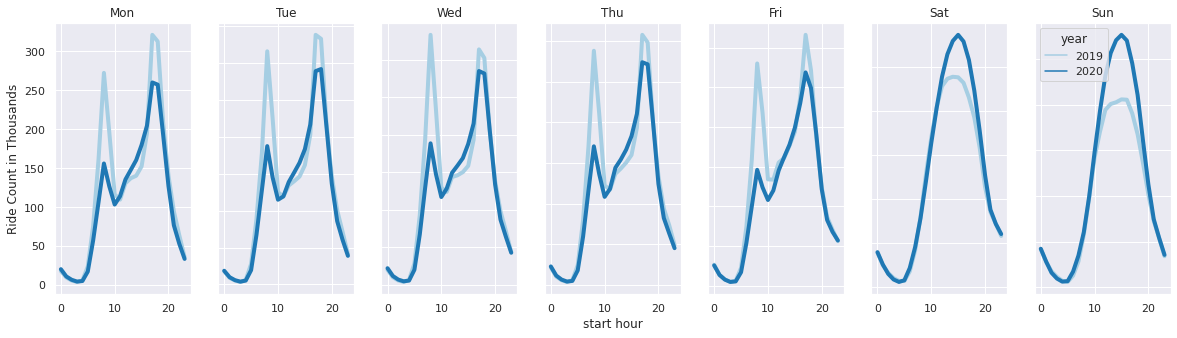

In [19]:
sns.set(font_scale = 1)
fig, ax = plt.subplots(1,7, figsize=(20,5)) 

days=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

for d in range(len(days)):
    sns.lineplot(ax=ax[d], data=count_hr[count_hr.weekday==d], linewidth=4,\
             x="start hour", y="Ride Count", hue='year',  palette='Paired')\
            .set_title(days[d]) ;
    if ~d:
        ax[d].set_ylabel('Ride Count in Thousands')
    if d:
        ax[d].set_ylabel('')
        ax[d].set_yticklabels('')
    if d != 3:
        ax[d].set_xlabel('')
    if d < 6:
        ax[d].legend_.remove()   


### Trip Duration

Create new data frame with trip duration (in seconds)

In [20]:
 df = pd.read_parquet('tripdata' , columns=['year','month','tripduration']) 

Convert seconds to minutes (keeping decimal portion)

In [21]:
df.tripduration /= 60

Calculate median trip duration by year/month.  
Display in wide format to 100ths of a minute.

In [22]:
dur = df.groupby(["year", "month"]).agg('median')
dur.unstack().round(2)

tripduration                                                         \
month           1     2      3      4      5      6      7      8      9    
year                                                                        
2019          8.40  8.63   8.98  10.08  10.88  11.38  10.97  11.23  11.13   
2020          8.82  8.68  11.33  16.17  18.28  17.13  14.63  14.40  13.75   

                            
month     10     11     12  
year                        
2019   10.28   9.37   8.70  
2020   12.55  11.77  10.27

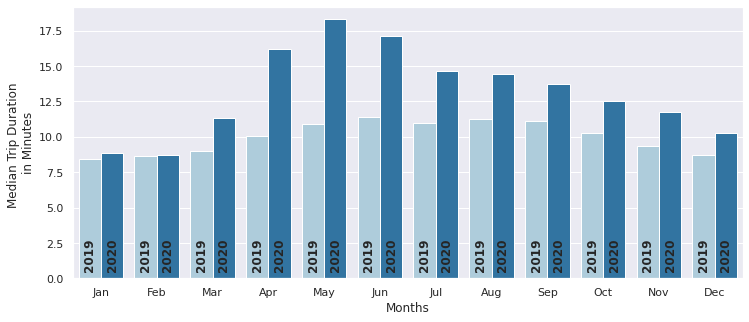

In [23]:
dur.reset_index( level = ['year','month'], inplace=True)
sns.set(font_scale = 1)
plt.figure(figsize=(12,5))

ax=sns.barplot(data=dur, x="month" , y='tripduration',  hue='year', palette='Paired' )
ax.set_xlabel("Months") 
ax.set_ylabel("Median Trip Duration \nin Minutes") 
ax.set_xticklabels(months)
ax.legend_.remove()
y=0
for p in  ax.patches: 
    ax.annotate(counts.year[y],   (p.get_x() + p.get_width()/ 2, 0), rotation=90,\
    ha='center', size=12, fontweight='bold',  xytext=(0, 10),  textcoords='offset points')  
    y+=1